<a href="https://colab.research.google.com/github/nullvoid-ky/introduction-to-machine-learning-and-deep-learning/blob/main/bankruptcy_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bankruptcy Feature Selection: 5-Method Importance Playbook

This notebook computes feature importance **using five complementary methods** to help you pick 5–7 attributes for classification:

1. Random Forest (built-in Gini/MDI)
2. Gradient Boosting (built-in importance)
3. Permutation Feature Importance (model-agnostic)
4. SHAP (TreeExplainer over a tree model)
5. Logistic Regression Coefficients (after scaling)

**Dataset**: `utkarshx27/american-companies-bankruptcy-prediction-dataset` via `kagglehub` (as requested).

Outputs:
- Per-method importance tables
- A combined ranking table (average rank & consensus)
- Simple matplotlib bar charts

> Tip: After you review the final combined ranking, pick your **Top 5–7 features** to train your classification model pipeline.

In [1]:
# ===== Setup & Installs (Kaggle usually has most of these; safe to re-run) =====
!pip -q install kagglehub shap lightgbm xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance

import shap
import warnings
warnings.filterwarnings('ignore')


## Load Dataset via `kagglehub`
The code below follows your given pattern. Update `file_path` to the CSV within the dataset if needed.

**Expected columns** (as provided):
- `company_name` (drop)  
- `status_label` (target)  
- `year` (1999–2018)  
- `X1 … X18` with meanings per your mapping


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utkarshx27/american-companies-bankruptcy-prediction-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.47M/4.47M [00:00<00:00, 6.29MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/versions/3


In [5]:
from kagglehub import KaggleDatasetAdapter, load_dataset

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Set the CSV file path **inside** the dataset (adjust if needed)
# Explore the dataset directory printed below to confirm the file name.
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
file_path = "/root/.cache/kagglehub/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/versions/3/american_bankruptcy.csv"

df = pd.read_csv(file_path)

print("Loaded shape:", df.shape)
print("Columns:\n", list(df.columns))
df.head()

Loaded shape: (78682, 21)
Columns:
 ['company_name', 'status_label', 'year', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


## Basic Preprocessing
- Drop `company_name` (ID-like)
- Keep `year` as numeric (or one-hot encode later if needed)
- Define feature list (exclude `status_label`)
- Impute missing values (median)
- Split into train/test (stratified)


In [7]:
# Drop obvious non-feature column(s)
df_proc = df.copy()
if 'company_name' in df_proc.columns:
    df_proc = df_proc.drop(columns=['company_name'])

target_col = 'status_label'
assert target_col in df_proc.columns, "status_label (target) not found!"

# Identify feature columns (all except target)
feature_cols = [c for c in df_proc.columns if c != target_col]

# Train/Test Split
X = df_proc[feature_cols]
y = df_proc[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Numeric pipeline: impute median (you can add scaler per-model later)
numeric_features = feature_cols
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)],
    remainder='drop'
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Train shape: (59011, 19)  Test shape: (19671, 19)


## 1) Random Forest Importance

In [9]:
rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=4,
        max_depth=None,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
    ))
])
rf_pipe.fit(X_train, y_train)
rf = rf_pipe.named_steps['rf']

# Extract fitted features order from ColumnTransformer
feat_names = numeric_features
rf_importance = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)
print(rf_importance.head(10))
rf_importance_df = rf_importance.reset_index()
rf_importance_df.columns = ['feature', 'rf_importance']
rf_importance_df.head()

year    0.073888
X15     0.071160
X8      0.067815
X6      0.061435
X13     0.058389
X11     0.055379
X1      0.054995
X12     0.054860
X7      0.052408
X17     0.051968
dtype: float64


,feature,rf_importance
0,year,0.073888
1,X15,0.071160
2,X8,0.067815
3,X6,0.061435
4,X13,0.058389


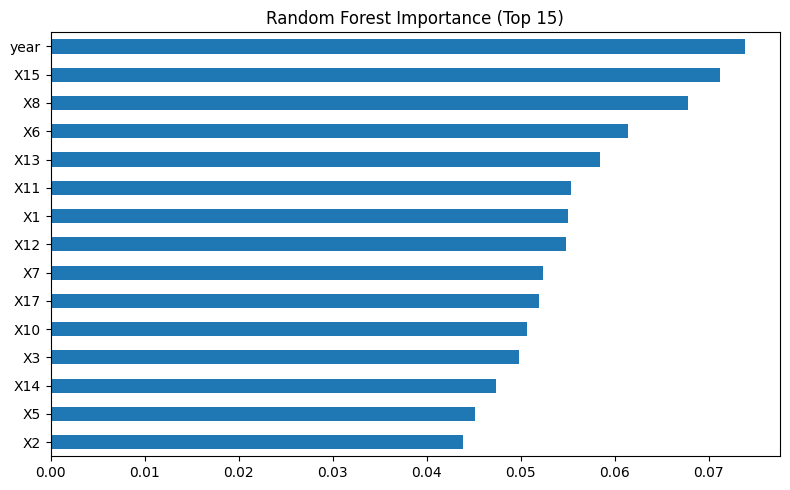

In [10]:
# Plot RF importances
plt.figure(figsize=(8,5))
rf_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('Random Forest Importance (Top 15)')
plt.tight_layout()
plt.show()

## 2) Gradient Boosting Importance (sklearn GBDT)
*(You can switch to XGBoost/LightGBM if preferred — both also expose built-in importance like `gain`.)*

In [11]:
gb_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("gb", GradientBoostingClassifier(random_state=42))
])
gb_pipe.fit(X_train, y_train)
gb = gb_pipe.named_steps['gb']
gb_importance = pd.Series(gb.feature_importances_, index=feat_names).sort_values(ascending=False)
print(gb_importance.head(10))
gb_importance_df = gb_importance.reset_index(); gb_importance_df.columns = ['feature','gb_importance']
gb_importance_df.head()

X8      0.147056
year    0.142118
X6      0.122220
X11     0.084288
X3      0.071333
X17     0.052114
X13     0.051508
X5      0.048150
X18     0.043496
X15     0.040045
dtype: float64


,feature,gb_importance
0,X8,0.147056
1,year,0.142118
2,X6,0.122220
3,X11,0.084288
4,X3,0.071333


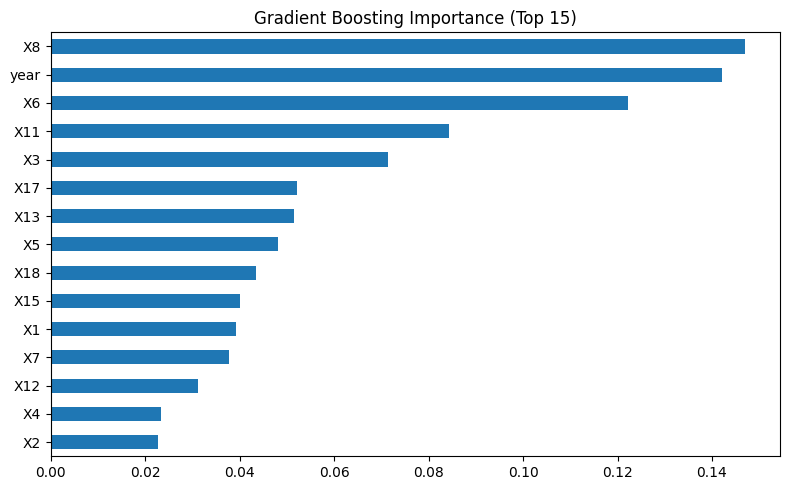

In [12]:
plt.figure(figsize=(8,5))
gb_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('Gradient Boosting Importance (Top 15)')
plt.tight_layout()
plt.show()

## 3) Permutation Feature Importance (model-agnostic on RF model)
Runs on the **validation** set to estimate performance drop when shuffling each feature.

In [13]:
rf_pipe_score = rf_pipe.score(X_test, y_test)
perm = permutation_importance(rf_pipe, X_test, y_test, n_repeats=4, random_state=42, n_jobs=-1)
perm_scores = pd.Series(perm.importances_mean, index=feat_names).sort_values(ascending=False)
print("Base RF score:", rf_pipe_score)
print(perm_scores.head(10))
perm_df = perm_scores.reset_index(); perm_df.columns = ['feature','perm_importance']
perm_df.head()

Base RF score: 0.9355396268618779
X8     0.002288
X11    0.002097
X17    0.001995
X7     0.001995
X14    0.001830
X15    0.001754
X2     0.001690
X3     0.001652
X13    0.001551
X1     0.001436
dtype: float64


,feature,perm_importance
0,X8,0.002288
1,X11,0.002097
2,X17,0.001995
3,X7,0.001995
4,X14,0.001830


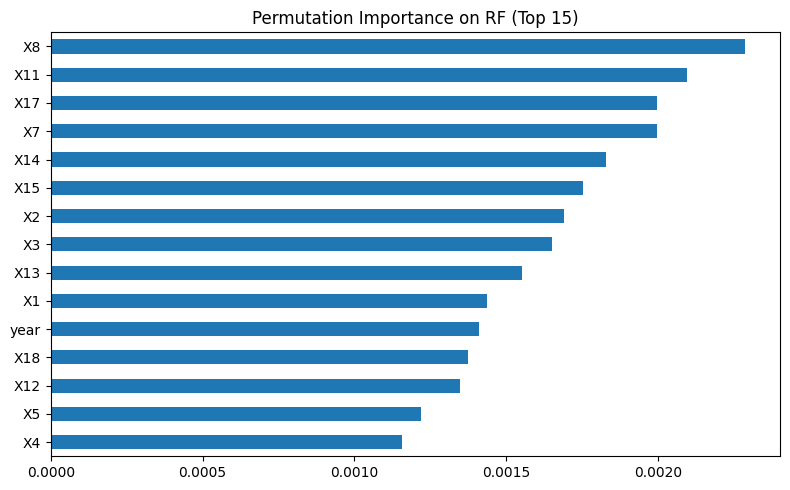

In [14]:
plt.figure(figsize=(8,5))
perm_scores.head(15).iloc[::-1].plot(kind='barh')
plt.title('Permutation Importance on RF (Top 15)')
plt.tight_layout()
plt.show()

## 4) SHAP (TreeExplainer on RF)
We take **mean absolute SHAP value** per feature on the validation set as global importance.

In [22]:
# Build a fresh RF (fitted) object on imputed data to pass raw arrays to SHAP
X_train_imp = preprocess.fit_transform(X_train)
X_test_imp = preprocess.transform(X_test)
rf_shap = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42, n_jobs=-1)
rf_shap.fit(X_train_imp, y_train)

explainer = shap.TreeExplainer(rf_shap)
shap_values = explainer.shap_values(X_test_imp)
if isinstance(shap_values, list):
    # For binary classification, take class 1 contributions
    sv = shap_values[1]
else:
    sv = shap_values
# หลังได้ sv มาแล้ว
sv_abs = np.abs(sv)
if sv_abs.ndim == 3:
    # (n_samples, n_features, n_outputs)
    shap_abs_mean = sv_abs.mean(axis=(0, 2))
elif sv_abs.ndim == 2:
    # (n_samples, n_features)
    shap_abs_mean = sv_abs.mean(axis=0)
else:
    raise ValueError(f"Unexpected SHAP shape: {sv_abs.shape}")

shap_importance = pd.Series(shap_abs_mean, index=feat_names).sort_values(ascending=False)

print(shap_importance.head(10))
shap_df = shap_importance.reset_index(); shap_df.columns = ['feature','shap_importance']
shap_df.head()

year    0.032322
X8      0.031286
X3      0.030738
X6      0.028994
X1      0.028080
X17     0.026898
X13     0.026376
X7      0.025977
X15     0.025666
X10     0.024017
dtype: float64


,feature,shap_importance
0,year,0.032322
1,X8,0.031286
2,X3,0.030738
3,X6,0.028994
4,X1,0.028080


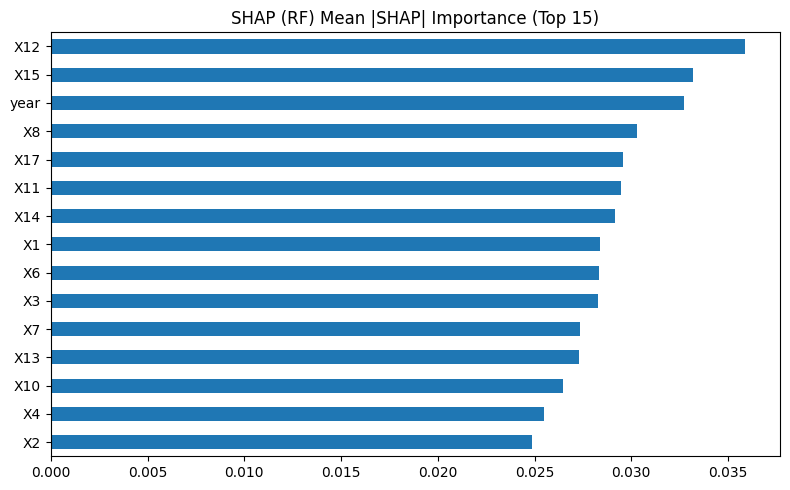

In [21]:
plt.figure(figsize=(8,5))
shap_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('SHAP (RF) Mean |SHAP| Importance (Top 15)')
plt.tight_layout()
plt.show()

## 5) Logistic Regression Coefficients (after scaling)
We use absolute coefficient magnitude as global importance.
- Pipeline: Impute → Scale → LogisticRegression
- For binary target, take `abs(coef_)`. If OvR, average abs across classes.

In [16]:
logit_pipe = Pipeline(steps=[
    ("prep", ColumnTransformer([
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), numeric_features),
    ], remainder='drop')),
    ("logit", LogisticRegression(max_iter=2000, class_weight='balanced', solver='lbfgs')),
])
logit_pipe.fit(X_train, y_train)
logit = logit_pipe.named_steps['logit']

coefs = logit.coef_
if coefs.ndim == 1:
    coef_abs = np.abs(coefs)
else:
    coef_abs = np.mean(np.abs(coefs), axis=0)
logit_importance = pd.Series(coef_abs, index=feat_names).sort_values(ascending=False)
print(logit_importance.head(10))
logit_df = logit_importance.reset_index(); logit_df.columns = ['feature','logit_importance']
logit_df.head()

X8      2.679555
X1      1.605701
X17     0.976787
X3      0.831117
X12     0.737278
X14     0.718717
X5      0.518049
year    0.384769
X10     0.357059
X4      0.289506
dtype: float64


,feature,logit_importance
0,X8,2.679555
1,X1,1.605701
2,X17,0.976787
3,X3,0.831117
4,X12,0.737278


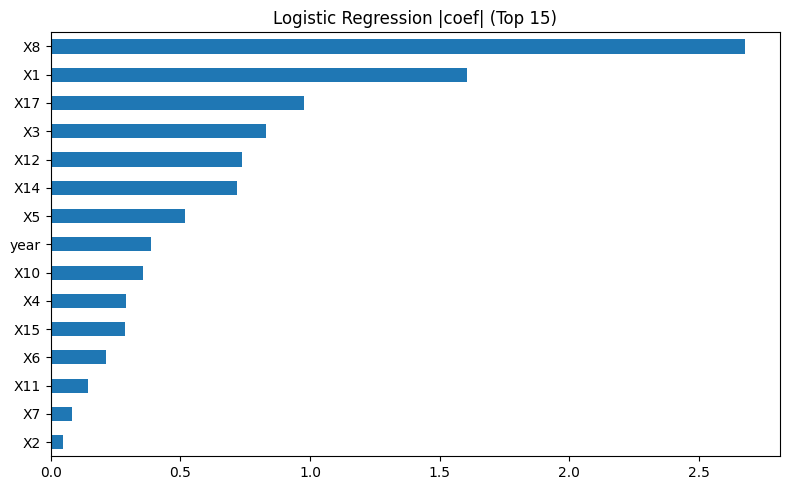

In [17]:
plt.figure(figsize=(8,5))
logit_importance.head(15).iloc[::-1].plot(kind='barh')
plt.title('Logistic Regression |coef| (Top 15)')
plt.tight_layout()
plt.show()

## Combine Rankings
We convert each method’s importances into ranks (1 = most important), then compute **average rank** and **consensus count** (how many methods put the feature in Top-k).

In [19]:
dfs = [rf_importance_df, gb_importance_df, perm_df, logit_df]
merged = None
for d in dfs:
    merged = d if merged is None else merged.merge(d, on='feature', how='outer')

# Fill missing with 0 importance (if any)
for c in merged.columns:
    if c != 'feature':
        merged[c] = merged[c].fillna(0.0)

# Create per-method ranks (1=best). Use rank(ascending=False).
rank_cols = []
for c in merged.columns:
    if c != 'feature':
        rname = c + '_rank'
        merged[rname] = merged[c].rank(ascending=False, method='average')
        rank_cols.append(rname)

merged['avg_rank'] = merged[rank_cols].mean(axis=1)
merged_sorted = merged.sort_values('avg_rank', ascending=True)
merged_sorted.head(15)

,feature,rf_importance,gb_importance,perm_importance,logit_importance,rf_importance_rank,gb_importance_rank,perm_importance_rank,logit_importance_rank,avg_rank
16,X8,0.067815,0.147056,0.002288,2.679555,3.0,1.0,1.0,1.0,1.500
18,year,0.073888,0.142118,0.001411,0.384769,1.0,2.0,11.0,8.0,5.500
8,X17,0.051968,0.052114,0.001995,0.976787,10.0,6.0,3.5,3.0,5.625
2,X11,0.055379,0.084288,0.002097,0.143085,6.0,4.0,2.0,13.0,6.250
11,X3,0.049805,0.071333,0.001652,0.831117,12.0,5.0,8.0,4.0,7.250
6,X15,0.071160,0.040045,0.001754,0.287402,2.0,10.0,6.0,11.0,7.250
0,X1,0.054995,0.039254,0.001436,1.605701,7.0,11.0,10.0,2.0,7.500
14,X6,0.061435,0.122220,0.001093,0.213372,4.0,3.0,17.0,12.0,9.000
15,X7,0.052408,0.037675,0.001995,0.079842,9.0,12.0,3.5,14.0,9.625
3,X12,0.054860,0.031169,0.001347,0.737278,8.0,13.0,13.0,5.0,9.750


Top-15 features by average rank:


,feature,avg_rank,rf_importance_rank,gb_importance_rank,perm_importance_rank,logit_importance_rank,avg_rank
16,X8,1.500,3.0,1.0,1.0,1.0,1.500
18,year,5.500,1.0,2.0,11.0,8.0,5.500
8,X17,5.625,10.0,6.0,3.5,3.0,5.625
2,X11,6.250,6.0,4.0,2.0,13.0,6.250
11,X3,7.250,12.0,5.0,8.0,4.0,7.250
6,X15,7.250,2.0,10.0,6.0,11.0,7.250
0,X1,7.500,7.0,11.0,10.0,2.0,7.500
14,X6,9.000,4.0,3.0,17.0,12.0,9.000
15,X7,9.625,9.0,12.0,3.5,14.0,9.625
3,X12,9.750,8.0,13.0,13.0,5.0,9.750


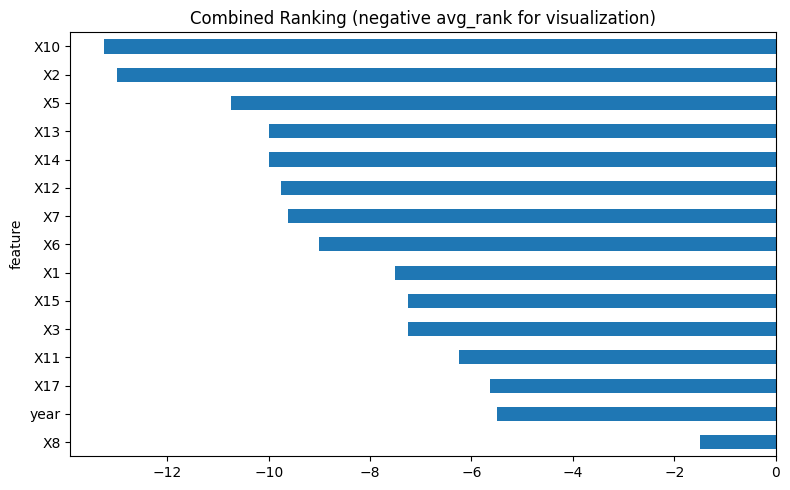

In [26]:
from math import ceil
TOP_K = 15
topk = merged_sorted.head(TOP_K).copy()
print("Top-{} features by average rank:".format(TOP_K))
display(topk[['feature','avg_rank'] + [c for c in merged.columns if c.endswith('_rank')]])

# Plot combined top-k by (negative avg_rank for bar chart convenience)
plt.figure(figsize=(8,5))
to_plot = topk.set_index('feature')['avg_rank'].sort_values(ascending=False)
( -to_plot ).iloc[::-1].plot(kind='barh')
plt.title('Combined Ranking (negative avg_rank for visualization)')
plt.tight_layout()
plt.show()

### Notes
- You can **swap GradientBoostingClassifier** for **XGBoost/LightGBM** and use their `feature_importances_` or Booster importance types (`gain`, `cover`).
- For **Permutation** and **SHAP**, you can run them on any trained model; here we used RF to keep runtime reasonable.
- After deciding your **Top 5–7 features**, re-train your classification model and report metrics: Accuracy, Precision/Recall, F1, ROC-AUC, Confusion Matrix, etc.